# Beautiful numbers - ML

## Load libraries and data

In [50]:
# pandas + numpy
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

#sklearn
from sklearn.model_selection import train_test_split

import sys
# append the path of the parent directory
sys.path.append("..")
from lib.utils import *


In [51]:
# prepare data
features = pd.read_csv('../data/nr_beauty_metrics.csv', dtype={'str_n':str})
target = pd.read_csv('../data/lottery_nr_sales.csv')

# Tune the parameters of the model to improve the R² (feature engineering)
features = features.drop(columns = ['is_odd', 'start_digit', 'n', 'str_n', 'leap_metric', 'odd_count', 'repeat_sum', 'has_repeated_digits','repeat_max', 'repeat_digit_count', 'dist_digits_count', 'ends_00', 'starts_00', 'is_prime', 'starts_15', 'ends_15'])

# get dummies 
features = pd.get_dummies(features, columns=['repeat_consec_max'], drop_first=True)

target = target['mean']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30, random_state=42)


In [52]:
features.columns

Index(['contains_13', 'ends_0', 'ends_13', 'ends_5', 'ends_69', 'ends_7',
       'ends_prime', 'starts_0', 'starts_13', 'starts_9', 'is_date',
       'is_palindrome', 'is_series', 'is_postal_code', 'repeat_consec_max_2',
       'repeat_consec_max_3', 'repeat_consec_max_4', 'repeat_consec_max_5'],
      dtype='object')

## Compare Models

### Linear Regression

We will start by exploring a linear regression. 
This will tell us how the different features of our df impact the target, and if they are significative. 

In [47]:
df = pd.concat([features, target], axis=1)
all_columns = "+".join(features.columns)
res = smf.glm(formula="mean ~" + all_columns, data=df, family=sm.families.Binomial()).fit()
print(res.summary())

pred = res.predict(features)

# find the correlation between pred and target
print("R2: ", (np.corrcoef(pred, target)[1][0])**2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mean   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99981
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34285.
Date:                Wed, 23 Oct 2024   Deviance:                       11777.
Time:                        21:09:05   Pearson chi2:                 1.17e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.08060
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [48]:
# Let's analyse the impact (Odds Ratio) of each feature on the predicted target.
params = res.params 
conf = res.conf_int() 
conf['Odds Ratio'] = params 
conf.columns = ['5%', '95%', 'Odds Ratio'] 
print(np.exp(conf))

                                    5%        95%  Odds Ratio
Intercept                     4.858772   5.159521    5.006889
contains_13[T.True]           1.039636   1.335187    1.178180
ends_0[T.True]                0.561666   0.620671    0.590432
ends_13[T.True]              14.578318  47.690827   26.367633
ends_5[T.True]                2.284254   2.611273    2.442296
ends_69[T.True]               2.722118   4.381865    3.453687
ends_7[T.True]                2.275320   2.605208    2.434683
ends_prime[T.True]            0.943292   1.022132    0.981921
starts_0[T.True]              0.338478   0.374548    0.356057
starts_13[T.True]             1.694250   2.675304    2.128998
starts_9[T.True]              0.620050   0.686128    0.652253
is_date[T.True]               1.163928   1.254935    1.208575
is_palindrome[T.True]         1.021125   1.446059    1.215157
is_series[T.True]             0.402940  14.266202    2.397586
is_postal_code[T.True]        1.093027   1.216333    1.153033
repeat_c

**Learnings**

After choosing the parameters to optimise the R2 value (feature engineering), it seems that most of the features produce a significant impact on the sales mean (p < 0.05>). 
Only repeat_consec_max_5 and is_series are less likely to be significant. This is probably because there are very few numbers that belong to these categories, but the effect of this params is quite considerable, so we'll leave them in the model for now. 

### ML models

In [49]:
compare_models(X_train, y_train, X_test, y_test)

Decision Tree
MAE 0.10077250537906975
RMSE 0.1349995622743164
R2 score 0.47174946816338625 

Random Forest
MAE 0.10074214277065942
RMSE 0.1349174831262509
R2 score 0.4723916209532565 

Linear Regressor
MAE 0.1050882774085152
RMSE 0.13956373337707423
R2 score 0.43542664315377977 



KeyboardInterrupt: 

**Learnings**:

We will use the xgboost model. It's one of the models that offers best results (almost as good as Random Forest). 
t will also allow us to use shap to explain the model predictions. 

## XGBoost and Shap

In [53]:
import xgboost as xgb

# train an XGBoost model
xgb_model = xgb.XGBRegressor().fit(X_train, y_train)

print("R2 score", xgb_model.score(X_test, y_test), "\n")


# train shap explainer
import shap # package used to calculate Shap values

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(features)

R2 score 0.47278821321261 



In [54]:
import pickle

# Save models to pickel files
pickle.dump(shap_values, open('../models/shapvalues.sav', 'wb'))
pickle.dump(xgb_model, open('../models/xgb_model.pkl', 'wb'))
pickle.dump(explainer, open('../models/shap_model.pkl', 'wb'))

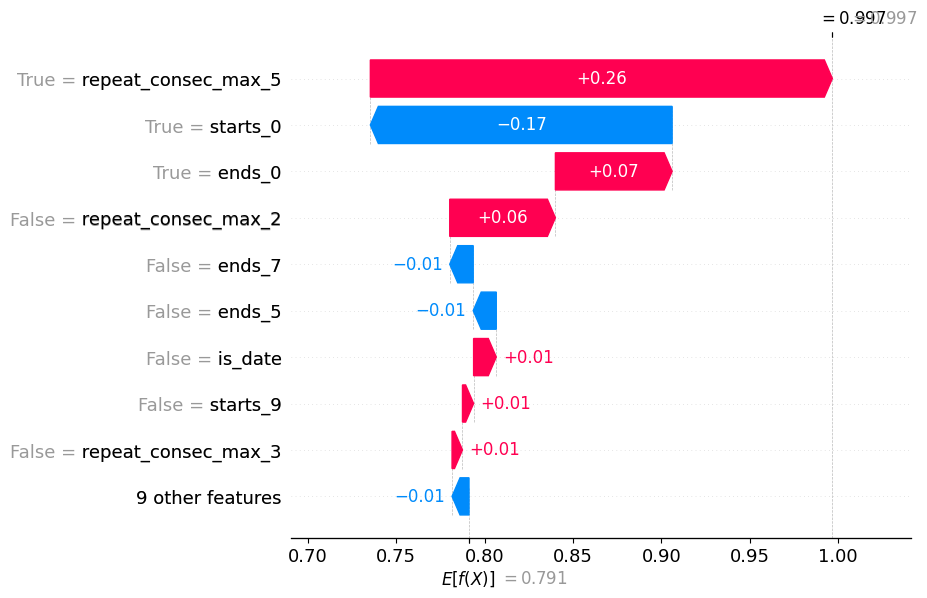

In [55]:
shap.plots.waterfall(shap_values[0])
